In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
import scipy as sp

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict

import lightgbm as lgb
import re

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

## Mean Target Encoding

In [4]:
class MeanTargetEncoding(BaseEstimator, ClassifierMixin):
    def __init__(self, cat_columns, target_name, alpha=100):
        self.cat_columns = cat_columns
        self.target_name = target_name
        self.mean_encodings = {}
        self.alpha = alpha
        
    def fit(self, X, y=None):
        self.global_mean = X[self.target_name].mean()
        
        def smoothing(x):
            return (x.mean() * len(x) + self.global_mean * self.alpha) / (len(x) + self.alpha)    

        for col in self.cat_columns:
            self.mean_encodings[col] = X.groupby(col)[self.target_name].apply(smoothing)
            
    def predict(self, X):
        X_new = np.zeros(shape=(len(X), len(self.cat_columns)))

        for index, col in enumerate(self.cat_columns):    
            X_new[:, index] = X.loc[:, col].map(self.mean_encodings[col]).fillna(self.global_mean).values

        return X_new

## Paths

In [5]:
TRAIN_PATH     = os.path.join(basepath, 'data/processed/train_text.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test_text.feather')
INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission20.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev6/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev6/val.feather')
# INTERIM_PATH   = os.path.join(basepath, 'data/interim/submission20_val.feather')

## Load Data

In [6]:
%%time

train  = pd.read_feather(f'{TRAIN_PATH}')
test   = pd.read_feather(f'{TEST_PATH}')

CPU times: user 404 ms, sys: 193 ms, total: 597 ms
Wall time: 596 ms


## Feature Engineering

In [7]:
# first keyword of the subject
train.loc[:, 'first_keyword'] = train.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0]))
test.loc[:, 'first_keyword']  = test.subject.map(lambda x: re.sub(r'[^A-Za-z0-9]', '', x.split()[0]))

### MTE

In [8]:
%%time

# is_click
mte_click         = MeanTargetEncoding(['user_id'], target_name='is_click')
mte_click_encoded = cross_val_predict(mte_click, train, y=train.is_click, cv=5, n_jobs=-1)

user_click_mte = pd.DataFrame(mte_click_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# is_open
mte_open         = MeanTargetEncoding(['user_id'], target_name='is_open')
mte_open_encoded = cross_val_predict(mte_open, train, y=train.is_open, cv=5, n_jobs=-1)

user_open_mte = pd.DataFrame(mte_open_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=train.index.values
            )

# first keyword subject
mte_keyword         = MeanTargetEncoding(['first_keyword'], target_name='is_click')
mte_keyword_encoded = cross_val_predict(mte_keyword, train, y=train.is_click, cv=5, n_jobs=-1)

keyword_mte = pd.DataFrame(mte_keyword_encoded,
                           columns=['%s_click_mte_mean'%col for col in ['first_keyword']],
                           index=train.index.values
                          )

# generate for test
mte_click.fit(train, train.is_click)
mte_click_test_encoded = mte_click.predict(test)

mte_open.fit(train, train.is_open)
mte_open_test_encoded = mte_open.predict(test)

user_click_test =  pd.DataFrame(mte_click_test_encoded, 
            columns=['%s_click_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

user_open_test =  pd.DataFrame(mte_open_test_encoded, 
            columns=['%s_open_mte_mean'%col for col in ['user_id']],
            index=test.index.values
            )

keyword_test = pd.DataFrame(mte_open_test_encoded, 
                columns=['%s_click_mte_mean'%col for col in ['first_keyword']],
                index=test.index.values
               )

train = pd.concat((train, user_click_mte, user_open_mte, keyword_mte), axis=1)
test  = pd.concat((test, user_click_test, user_open_test, keyword_test), axis=1)

CPU times: user 1min 8s, sys: 6.21 s, total: 1min 14s
Wall time: 2min 40s


In [9]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

### User Features

** Load interim dataset **

In [37]:
traintest = pd.read_feather(f'{INTERIM_PATH}')

In [10]:
%%time

def get_most_sent_type(rows):
    return rows.communication_type.value_counts().index.values[0]

def get_avg_diff_send_date(x):
    if len(x) > 1:
        return x.sort_values(by='send_date').loc[:, 'send_date'].diff().dt.days.mean()
    else:
        return -1

traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

num_diff_email_types                     = traintest.groupby('user_id')['communication_type'].nunique()
traintest.loc[:, 'num_diff_email_types'] = traintest.user_id.map(num_diff_email_types)
    
most_sent_type = traintest.groupby('user_id').apply(get_most_sent_type)
traintest.loc[:, 'most_sent_type'] = traintest.user_id.map(most_sent_type)

diff_hour = traintest.groupby('user_id').apply(lambda x: x.send_date.dt.hour.nunique())
traintest.loc[:, 'diff_hour'] = traintest.user_id.map(diff_hour)

avg_diff_send_date = traintest.groupby('user_id').apply(get_avg_diff_send_date)
traintest.loc[:, 'avg_diff_send_date']  = traintest.user_id.map(avg_diff_send_date)

user_age = traintest.groupby('user_id').apply(lambda x: (x['send_date'].max() - x['send_date'].min()).days)
traintest.loc[:, 'user_age'] = traintest.user_id.map(user_age)

CPU times: user 8min 13s, sys: 2.94 s, total: 8min 16s
Wall time: 8min 15s


** Save as interim dataset **

In [11]:
%%time

traintest.index = np.arange(len(traintest))
traintest.to_feather(f'{INTERIM_PATH}')

CPU times: user 699 ms, sys: 430 ms, total: 1.13 s
Wall time: 2.39 s


### Subject Line Based Features

In [12]:
%%time

# number of digits in the subject line.
digit_pattern      = re.compile(r'\d+')
traintest.loc[:, 'subject_num_digits'] = traintest.subject.map(lambda x: len(re.findall(digit_pattern, x)))

# whether subject line has punctuation or not.
punctuation_pattern = re.compile(r'[!.?\-",]+')
traintest.loc[:, 'subject_has_punctuation'] = traintest.subject.map(lambda x: int(len(re.findall(punctuation_pattern, x)) > 0))

# interaction between open rate and click rate.
traintest.loc[:, 'click_to_open']      = traintest.loc[:, 'user_id_click_mte_mean'] / traintest.loc[:, 'user_id_open_mte_mean']

# Number of keywords in subject.
traintest.loc[:, 'num_keywords']       = traintest.subject.map(lambda x: len(x.split(' ')))

# Number of short keywords in subject.
traintest.loc[:, 'num_short_keywords'] = traintest.subject.map(lambda x: len(list(filter(lambda x: len(x) > 4, x.split()))))

# Ratio of short to total keywords.
traintest.loc[:, 'ratio_short_total']  = traintest.num_short_keywords / traintest.num_keywords

# Total number of characters in the subject.
traintest.loc[:, 'num_characters']     = traintest.subject.map(lambda x: len(x))

# Number of times first keyword was used in the past
traintest.loc[:, 'first_keyword_count'] = traintest.groupby('first_keyword')['first_keyword'].transform(lambda x: len(x))

CPU times: user 26 s, sys: 2.04 s, total: 28 s
Wall time: 30 s
Parser   : 162 ms


** Feature Namespace **

In [13]:
FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
            'num_emails_sent', 'num_diff_email_types', 
            'most_sent_type', 'diff_hour', 'avg_diff_send_date',
            'user_id_click_mte_mean', 'user_id_open_mte_mean',
            'user_age','subject_num_digits', 'subject_has_punctuation',
            'click_to_open', 'num_keywords', 'num_short_keywords',
            'ratio_short_total', 'num_characters', 'first_keyword_click_mte_mean',
            'first_keyword_count'
           ]

** Missing values count **

In [14]:
traintest.loc[:, FEATURES].isnull().sum()

communication_type              0
send_day                        0
send_hour                       0
send_weekday                    0
total_links                     0
no_of_internal_links            0
no_of_images                    0
no_of_sections                  0
num_emails_sent                 0
num_diff_email_types            0
most_sent_type                  0
diff_hour                       0
avg_diff_send_date              0
user_id_click_mte_mean          0
user_id_open_mte_mean           0
user_age                        0
subject_num_digits              0
subject_has_punctuation         0
click_to_open                   0
num_keywords                    0
num_short_keywords              0
ratio_short_total               0
num_characters                  0
first_keyword_click_mte_mean    0
first_keyword_count             0
dtype: int64

** Train Test Split **

In [15]:
len(traintest), ntrain

(1797049, 1023191)

In [16]:
X_trn = traintest.iloc[:ntrain].loc[:, FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click'].values

X_val = traintest.iloc[ntrain:].loc[:, FEATURES]
y_val = traintest.iloc[ntrain:]['is_click'].values

print(X_trn.shape, X_val.shape)

del traintest
gc.collect();

(1023191, 25) (773858, 25)


## Validation

In [48]:
params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': .1,
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'lambda_l1': 2,
    'nthread': 4
}

ltrain = lgb.Dataset(X_trn, y_trn, feature_name=FEATURES)
leval  = lgb.Dataset(X_val, y_val, feature_name=FEATURES)

valid_sets  = [ltrain, leval]
valid_names = ['train', 'eval']

num_boost_round       = 1000
early_stopping_rounds = 100

m = lgb.train(params, 
              ltrain, 
              num_boost_round, 
              early_stopping_rounds=early_stopping_rounds, 
              valid_names=valid_names,
              valid_sets=valid_sets,
              verbose_eval=20)

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.733491	eval's auc: 0.696639
[40]	train's auc: 0.74077	eval's auc: 0.704169
[60]	train's auc: 0.748397	eval's auc: 0.711628
[80]	train's auc: 0.755836	eval's auc: 0.71009
[100]	train's auc: 0.75999	eval's auc: 0.70988
[120]	train's auc: 0.764219	eval's auc: 0.708445
[140]	train's auc: 0.768025	eval's auc: 0.708991
Early stopping, best iteration is:
[51]	train's auc: 0.74513	eval's auc: 0.713365


```
[79]	train's auc: 0.750955	eval's auc: 0.712894
[51]	train's auc: 0.74513	eval's auc: 0.713365
```

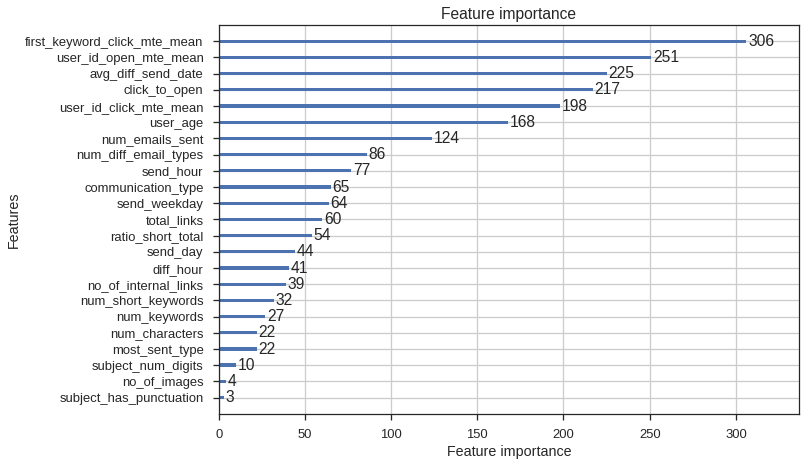

In [36]:
lgb.plot_importance(m);

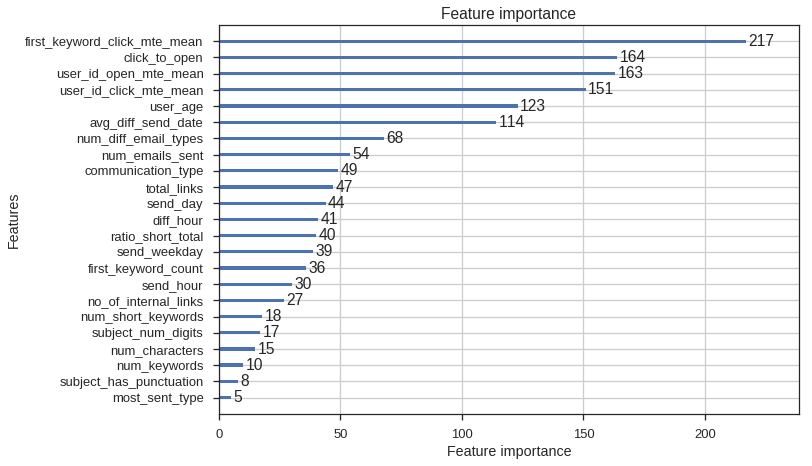

In [49]:
lgb.plot_importance(m);

## Full Training

In [17]:
%%time

params = {
    'application': 'binary',
    'metric': 'auc',
    'learning_rate': (.1 / 1.1),
    'min_data_in_leaf': 20,
    'num_leaves': 31,
    'feature_fraction': .7,
    'feature_fraction_seed': SEED,
    'lambda_l1': 2,
    'nthread': 4
}

ltrain          = lgb.Dataset(X_trn, y_trn)
num_boost_round = int(51 * 1.1)

m = lgb.train(params, 
              ltrain, 
              num_boost_round)

preds = m.predict(X_val)

CPU times: user 30.4 s, sys: 559 ms, total: 30.9 s
Wall time: 9.42 s


## Submission

In [18]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission20.csv', index=False)